#***Text classification and Authorship Attribution***


In this notebook I will be using various algorithms for text classification, performing an
authorship attribution task on Donald Trump’s
tweets.


###***Classification: Who Controls this Account***

Politicians, as well as other public figures, usually have assistants and staffers that manage
most of their social media presence. 

However, like many other norm defying actions, Donald
Trump, the 45th President of the United States is taking pride in his untamed use of Twitter. 

At times, during the presidential campaign, it was [hypothesized](https://www.theatlantic.com/politics/archive/2016/08/donald-trump-twitter-iphone-android/495239/) that Donald Trump is being
kept away from his Twitter account in order to avoid unnecessary PR calamities. 

Trump’s tweets
are not explicitly labeled (Hillary Clinton, for example, used to sign tweets composed by her by
an addition of ‘-H’ at the end of the tweet while unsigned tweets were posted by her staffers). 

It is known, however, that Trump was using an android phone while the staffers were most likely** to use an iPhone.

Luckily, the device information is part of the data available via the Twitter API, hence the device used can be used as an authorship label.




---


** Trump switched to a secured iPhone in April 2017, hence, building an accurate authorship
model on older data can be used for authorship attribution of newer tweets.

In [ ]:
!pip install tensorflow

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl

import nltk
# Commented out IPython magic to ensure Python compatibility.
nltk.download('stopwords')

import numpy as np
import pandas as pd
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import string
from collections import Counter
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

import tensorflow as tf
import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Data understanding**

##Collect initial data

In [5]:
def load_data(path="/content/drive/MyDrive/ex2_data/trump_train.tsv", train=True):
  df = pd.read_csv(path, sep='\t', names=['user handle', 'tweet text', 'time stamp', 'device'], quoting=3)
  df = df[(df['device'] == 'android') | (df['device'] == 'iphone')]
  df['time stamp'] = pd.to_datetime(df['time stamp'], format='%Y-%m-%d %H:%M:%S')
  df.dropna(inplace=True)
  df.reset_index(drop=True, inplace=True)

  df['class'] = df['device'].apply(lambda x: 0 if x == 'android' else 1)
  return df


trump_data = load_data()

##Dataset overview

In [6]:
trump_data

,user handle,tweet text,time stamp,device,class
0,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone,1
1,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone,1
2,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android,0
3,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android,0
4,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android,0
...,...,...,...,...,...
3247,realDonaldTrump,Off to Indiana! #Trump2016 https://t.co/zqUdaa...,2016-04-20 18:03:10,iphone,1
3248,realDonaldTrump,Thank you Indiana! Will be back soon! #Trump20...,2016-04-21 01:50:04,iphone,1
3249,realDonaldTrump,Had a meeting with the terrific @GovPenceIN of...,2016-04-21 04:58:17,iphone,1
3250,realDonaldTrump,We are going to bring steel and manufacturing ...,2016-04-21 04:58:27,iphone,1


class == 0 means Trump tweet. 

In [7]:
trump_data.dtypes

user handle            object
tweet text             object
time stamp     datetime64[ns]
device                 object
class                   int64
dtype: object

In [8]:
trump_data.isna().sum()

user handle    0
tweet text     0
time stamp     0
device         0
class          0
dtype: int64

First 10 Tweets 

In [9]:
for i in range(10):
  print(trump_data['tweet text'][i] + '\n')

Democrats are smiling in D.C. that the Freedom Caucus, with the help of Club For Growth and Heritage, have saved Planned Parenthood &amp; Ocare!

General Kelly is doing a great job at the border. Numbers are way down. Many are not even trying to come in anymore.

The race for DNC Chairman was, of course, totally "rigged." Bernie's guy, like Bernie himself, never had a chance. Clinton demanded Perez!

For first time the failing @nytimes will take an ad (a bad one) to help save its failing reputation. Try reporting accurately &amp; fairly!

Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

Big dinner with Governors tonight at White House. Much to be discussed, including healthcare.

Congressman John Lewis should spend more time on fixing and helping his district, which is in horrible shape and falling apart (not to......

mention crime infested) rather than falsely complaining about the election resu

In [10]:
devices_list = trump_data['device'].unique()
print(devices_list)

['iphone' 'android']


In [11]:
devices_categorical = {
    'iphone': 'iphone',
    'android': 'android',
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'twitter',
    '<a href="http://instagram.com" rel="nofollow">Instagram</a>': 'instagram',
    '<a href="http://www.twitter.com" rel="nofollow">Twitter for BlackBerry</a>': 'twitter',
    '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>': 'twitter',
    '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'twitter',
    '<a href="https://periscope.tv" rel="nofollow">Periscope.TV</a>': 'periscope',
    '<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>': 'facebook'}

In [12]:
trump_data['device'] = trump_data['device'].apply(lambda device: devices_categorical[device])
trump_data.tail()

,user handle,tweet text,time stamp,device,class
3247,realDonaldTrump,Off to Indiana! #Trump2016 https://t.co/zqUdaa...,2016-04-20 18:03:10,iphone,1
3248,realDonaldTrump,Thank you Indiana! Will be back soon! #Trump20...,2016-04-21 01:50:04,iphone,1
3249,realDonaldTrump,Had a meeting with the terrific @GovPenceIN of...,2016-04-21 04:58:17,iphone,1
3250,realDonaldTrump,We are going to bring steel and manufacturing ...,2016-04-21 04:58:27,iphone,1
3251,realDonaldTrump,Thank you Maryland- what a great way to conclu...,2016-04-21 05:26:19,iphone,1


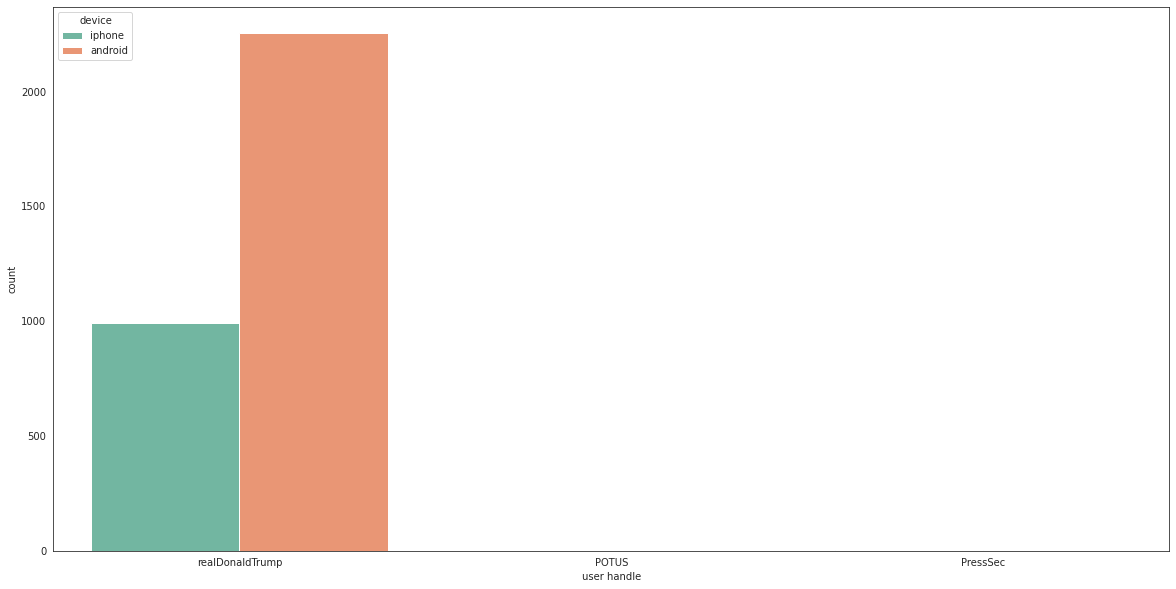

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x = 'user handle', hue='device', data=trump_data, palette="Set2")

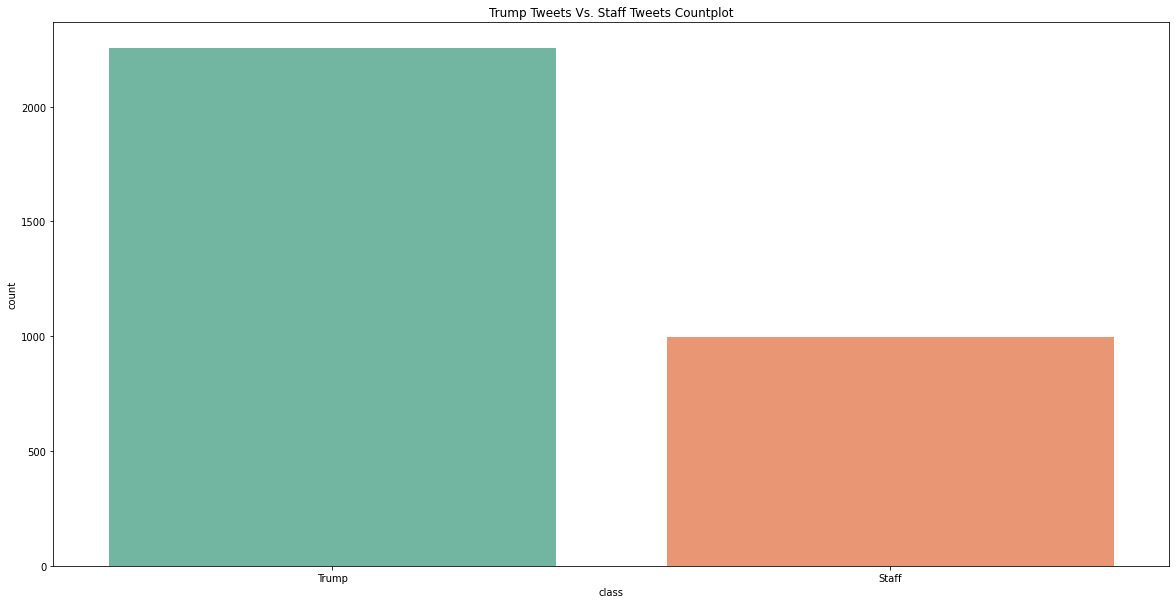

In [18]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='class',  data=trump_data, palette="Set2")
ax.set_title("Trump Tweets Vs. Staff Tweets Countplot")
ax.set_xticklabels(["Trump", "Staff"])
plt.show()

Extra: can you verify the claim that Trump was kept away from his Twitter account during the
campaign?


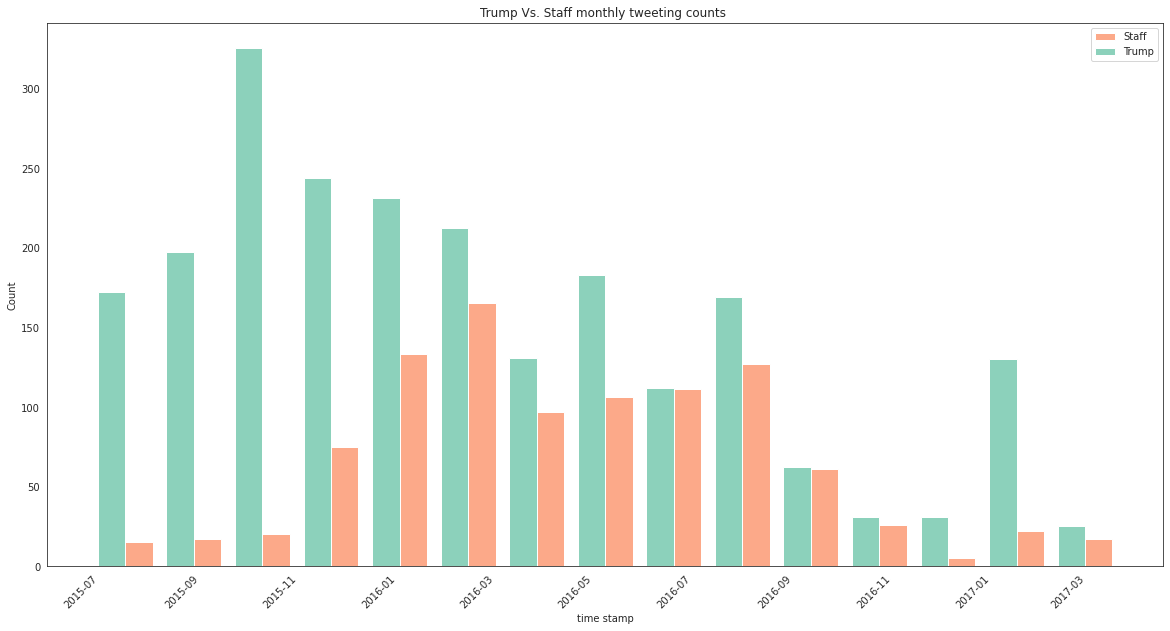

In [19]:
sns.set_style(style='white')
plt.figure(figsize=(20,10))
ax3 = sns.histplot(x= 'time stamp', hue= 'class', data=trump_data, bins=15,  palette="Set2", hue_order=[0, 1], multiple='dodge', shrink=0.8)
ax3.set_title("Trump Vs. Staff monthly tweeting counts ")
ax3 = plt.xticks(rotation = 45)
ax3 = plt.legend(("Staff", "Trump"))
plt.show()

Until May 2016, Trump dominated the Presidential Twitter account. Around July 2016, the trend changed as Trump's staff tweeted much often while Trump tweeted less often.  
Since the 2016 United States presidential election occurred on November 8, 2016, I think it is safe to claim that Trump was kept away from the Presidential Twitter account during the campaign.

#**Data Preparation**

In [20]:
def to_dummies(df, column):
  one_hot = pd.get_dummies(df[column])
  # Drop column model as it is now encoded
  df = df.drop([column],axis = 1)
  #join tables
  df = df.join([one_hot])
  return df

# Remove terms like links, digits, Unicode characters and more.
def text_preproc(x):
  x = x.lower()
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'http*\S+', ' ', x)
  #x = re.sub(r'@\S+', ' ', x)
  #x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  return x

# Remove square barackets
def remove_sq_brac(x):
  return re.sub('\[[^]]*\]', '', x)

# Cleaning the text
def clean_text(x):
    x = remove_sq_brac(x)
    x = text_preproc(x)
    return x

def urls_counter(text):
  url = re.findall(r'http*\S+',text)      
  return len([x[0] for x in url])

def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)

def add_tweet_length(text):
  return len(text.split(" "))

def remove_stopword(text):
  stop_words = stopwords.words('english')
  stopwords_dict = Counter(stop_words)
  text = ' '.join([word for word in text.split() if word not in stopwords_dict])
  return text

def day_time_param(hour):
  if 8 <= hour and hour < 12:
    return 'morning_tweet'
  if 12 <= hour and hour < 16:
    return 'noon_tweet'
  if 16 <= hour and hour < 20:
    return 'evening_tweet'
  return 'night_tweet'

def add_date_params(df):
  df['year'] = df['time stamp'].dt.year
  df['hour'] = df['time stamp'].apply(lambda x: day_time_param(x.hour))

def text_preparation(df, text_column, add_url_count=True):
  df[text_column] = df[text_column].apply(remove_spaces)
  df[text_column] = df[text_column].apply(remove_stopword)
  if add_url_count:
    df['urls count'] = df[text_column].apply(urls_counter)
  df[text_column] = df[text_column].apply(clean_text)
  return df

def features_preparation(df, text_column):
  df['tweet length'] = df[text_column].apply(add_tweet_length)
  add_date_params(df=df)
  df = to_dummies(df=df, column='hour')
  df = to_dummies(df=df, column='year')
  return df

In [21]:
def clean_data_pipline(df):
  df = text_preparation(df=df, text_column='tweet text')
  df = features_preparation(df=df, text_column='tweet text')
  df = df.drop(['user handle', 'time stamp', 'device'], axis=1)
  return df

I added nine features, derived from the given data -

URL count - number of links that occurred in the tweet.

Tweet length - number of words in the tweet.

Morning tweet - 1 if the tweet posted between 08:00-12:00

Noon tweet - 1 if the tweet posted between 12:00-16:00

Evening tweet - 1 if the tweet posted between 16:00-20:00

Night tweet - 1 if the tweet posted between 20:00-8:00

year - includes three features - 2015/2016/2017. The feature of the tweet's year will have 1 as value, while the others 0. 

In [22]:
trump_data = clean_data_pipline(df=trump_data)
trump_data.head()

,tweet text,class,urls count,tweet length,evening_tweet,morning_tweet,night_tweet,noon_tweet,2015,2016,2017
0,democrats smiling d c freedom caucus help club...,1,0,17,0,0,0,1,0,0,1
1,general kelly great job border numbers way dow...,1,0,14,0,0,1,0,0,0,1
2,the race dnc chairman was course totally rigge...,0,0,19,0,0,0,1,0,0,1
3,for first time failing nytimes take ad a bad o...,0,0,20,0,0,0,1,0,0,1
4,russia talk fake news put dems played media or...,0,0,16,0,0,1,0,0,0,1


In [23]:
trump_data.isna().sum()

tweet text       0
class            0
urls count       0
tweet length     0
evening_tweet    0
morning_tweet    0
night_tweet      0
noon_tweet       0
2015             0
2016             0
2017             0
dtype: int64

##Train-Test-Split

In [24]:
trump_train, trump_test = train_test_split(trump_data, test_size=0.20, shuffle=True)

In [25]:
trump_train.reset_index(drop=True, inplace=True)
trump_test.reset_index(drop=True, inplace=True)

In [26]:
trump_train

,tweet text,class,urls count,tweet length,evening_tweet,morning_tweet,night_tweet,noon_tweet,2015,2016,2017
0,just announced trump advertising rates debate ...,0,0,12,0,0,0,1,1,0,0
1,very sad happened last night miss universe pag...,0,0,19,0,0,0,1,1,0,0
2,another health insurer pulling back due financ...,1,1,13,0,0,1,0,0,1,0
3,thank today endorsement new york veteran polic...,1,2,10,0,0,1,0,0,1,0
4,thank idaho i love potatoes nobody grows bette...,1,1,14,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2596,thank you we make america great again,1,1,8,0,0,1,0,0,1,0
2597,a great day spencer amp davenport iowa thank y...,1,1,13,0,0,1,0,1,0,0
2598,big day texas tomorrow having rally fort worth...,1,1,13,0,1,0,0,0,1,0
2599,realdonaldtrump foxnews a must see trump bril...,0,0,13,0,0,1,0,1,0,0


In [27]:
trump_test

,tweet text,class,urls count,tweet length,evening_tweet,morning_tweet,night_tweet,noon_tweet,2015,2016,2017
0,wow failing nytimes reported properly crooked ...,0,0,14,0,0,0,1,0,1,0
1,makeamericagreatagain,1,1,3,0,0,0,1,1,0,0
2,really bad shooting orlando police investigati...,0,0,13,0,0,0,1,0,1,0
3,ragefelix governorpataki i lived in ny when t...,0,0,23,0,0,0,1,1,0,0
4,catonglass new followers realdonaldtrump from...,0,0,13,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
646,megyn kelly two really dumb puppets chris stir...,0,0,20,0,0,1,0,1,0,0
647,crooked hillary never able solve problems pove...,0,0,15,1,0,0,0,0,1,0
648,rt kellyannepolls polls continued hillary aver...,1,1,12,0,0,1,0,0,1,0
649,thebrodyfile on muslim issue it might help ba...,0,0,15,0,0,0,1,1,0,0


#**Modeling**

##Selecting modeling techniques

**Vectorizer**

I will use TF-IDF as a vectorizer.

In [28]:
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.8, use_idf=True, ngram_range=(1,3))

In [29]:
def transform_df_to_vectors(transformer, df, text_column):
  vectors = transformer.transform(df[text_column])
  vectors = pd.DataFrame(vectors.toarray(), columns=transformer.get_feature_names())
  vectors.reset_index(drop=True, inplace=True)
  return vectors

In [30]:
transformer = tfidf.fit(trump_train['tweet text'])

In [31]:
tfidf_vectors_train = transform_df_to_vectors(transformer=transformer, df=trump_train, text_column='tweet text')
tfidf_vectors_test = transform_df_to_vectors(transformer=transformer, df=trump_test, text_column='tweet text')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
tfidf_vectors_train

,again,all,also,amazing,america,america great,america great again,americafirst,american,amp,and,another,back,bad,beat,believe,bernie,best,better,big,bush,campaign,can,candidate,carolina,carson,clinton,cnn,could,country,crooked,crooked hillary,crooked hillary clinton,crowd,cruz,day,debate,dishonest,donald,donald trump,...,support,supporters,ted,ted cruz,thank,thank you,thanks,that,the,they,this,time,today,tomorrow,tonight,total,totally,trump,two,us,very,vote,wall,want,wants,watch,watching,way,we,well,what,why,will,win,would,wow,wrong,years,yesterday,you
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.429554,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.485353,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.313440,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.320438,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.348414,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.304907,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.75328,0.6577,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.468548,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.646854,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.60471,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.355713,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,0.282574,0.0,0.0,0.0,0.262369,0.304011,0.30702,0.0,0.0,0.000000,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.225844,0.288233,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.273405,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.250715
2597,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.317579,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.443528,0.000000,0.0,0.0,0.0,...,0.426439,0.0,0.0,0.0,0.275062,0.351048,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000

In [33]:
tfidf_vectors_test

,again,all,also,amazing,america,america great,america great again,americafirst,american,amp,and,another,back,bad,beat,believe,bernie,best,better,big,bush,campaign,can,candidate,carolina,carson,clinton,cnn,could,country,crooked,crooked hillary,crooked hillary clinton,crowd,cruz,day,debate,dishonest,donald,donald trump,...,support,supporters,ted,ted cruz,thank,thank you,thanks,that,the,they,this,time,today,tomorrow,tonight,total,totally,trump,two,us,very,vote,wall,want,wants,watch,watching,way,we,well,what,why,will,win,would,wow,wrong,years,yesterday,you
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.40605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344250,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.399236,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41502,0.0,0.000000,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.505742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.279356,0.000000,0.0,0.0,0.0,0.0,0.0,0.432512,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000
4,0.0,0.534632,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,0.0,0.429646,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.304681,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.451321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000
647,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.506698,0.357536,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.392037,0.402774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000
648,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0

***Adding non-words features***

In [34]:
def concat_vectors_and_features(vectors, df):
  return pd.concat([vectors, df], axis=1)

In [35]:
trump_train = concat_vectors_and_features(vectors=tfidf_vectors_train, df=trump_train.drop(['tweet text'], axis=1))

x_train = trump_train.drop(labels=['class'], axis=1)
y_train = trump_train['class']
print(x_train.shape, y_train.shape)

(2601, 209) (2601,)


In [36]:
trump_test = concat_vectors_and_features(vectors=tfidf_vectors_test, df=trump_test.drop(['tweet text'], axis=1))

x_test = trump_test.drop(labels=['class'], axis=1)
y_test = trump_test['class']
print(x_test.shape, y_test.shape)

(651, 209) (651,)


#Build models

***Evaluation function***

In [37]:
def eval_model(model, model_name, x_train, x_test, y_train, y_test, vectorizer):
  print('Presenting results of vectorizer: {}'.format(vectorizer))
  print('-------------------------------------------------------------')
  
  train_acc = '{:.4f}'.format(model.score(x_train, y_train))
  print('Accuracy of {} on training set: {}'
      .format(model_name, train_acc))
  test_acc = '{:.4f}'.format(model.score(x_test, y_test))
  print('Accuracy of {} on test set: {}\n'
      .format(model_name, test_acc))

***Confusion Matrix plot***

In [38]:
def model_plot_confusion_matrix(model, x_test, y_test, title):
  sns.set_style('white')
  fig = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, normalize='true')
  fig.ax_.set_title(title)
  plt.show()

***Cross validation***

In [39]:
def cross_val(model, model_name, x_train, y_train, vectorizer):
  result = sklearn.model_selection.cross_validate(model, x_train, y_train, return_estimator=True, return_train_score=True)
  print('\nPresenting results of vectorizer: {}'.format(vectorizer))
  print('-------------------------------------------------------------')
  print("Cross Validation iterations - test scores for {}: {}".format(model_name, result["test_score"]))
  print("Cross Validation iterations - train scores for {}: {}".format(model_name, result["train_score"]))

  #calculate average scores
  avg_test = "{:.4f}".format(sum(result["test_score"])/len(result["test_score"]))
  print("\n{} average test score: {}".format(model_name, avg_test))
  avg_train = "{:.4f}".format(sum(result["train_score"])/len(result["train_score"]))
  print("{} average train score: {}\n".format(model_name, avg_train))

  estimator = result['estimator']
  return estimator[np.argmax(result['test_score'])]

### Classifiers

***Logistic regression***


Presenting results of vectorizer: TF-IDF
-------------------------------------------------------------
Cross Validation iterations - test scores for Logistic Regression: [0.84644914 0.85384615 0.82884615 0.85961538 0.84807692]
Cross Validation iterations - train scores for Logistic Regression: [0.84903846 0.84718885 0.85199423 0.84478616 0.84814993]

Logistic Regression average test score: 0.8474
Logistic Regression average train score: 0.8482



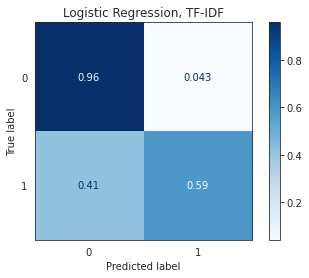

In [48]:
logistic_regression = LogisticRegression(C=0.01)
logistic_regression = cross_val(model=logistic_regression, model_name="Logistic Regression", x_train=x_train, y_train=y_train, vectorizer="TF-IDF")
model_plot_confusion_matrix(model=logistic_regression, x_test=x_test, y_test=y_test, title="Logistic Regression, TF-IDF")

***Linear SVC***


Presenting results of vectorizer: TF-IDF
-------------------------------------------------------------
Cross Validation iterations - test scores for Linear SVC: [0.91362764 0.86923077 0.86730769 0.88076923 0.85769231]
Cross Validation iterations - train scores for Linear SVC: [0.89951923 0.90004805 0.90004805 0.90052859 0.91254205]

Linear SVC average test score: 0.8777
Linear SVC average train score: 0.9025



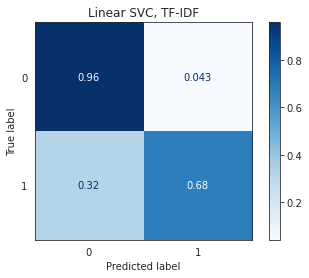

In [49]:
linear_svc = SVC(kernel='linear', C=1, random_state=0)
linear_svc = cross_val(model=linear_svc, model_name="Linear SVC", x_train=x_train, y_train=y_train, vectorizer="TF-IDF")
model_plot_confusion_matrix(model=linear_svc, x_test=x_test, y_test=y_test, title="Linear SVC, TF-IDF")

***Non-linear SVC***


Presenting results of vectorizer: TF-IDF
-------------------------------------------------------------
Cross Validation iterations - test scores for Non Linear SVC: [0.85988484 0.85961538 0.83461538 0.86153846 0.85576923]
Cross Validation iterations - train scores for Non Linear SVC: [0.85528846 0.85487746 0.86256607 0.85631908 0.85776069]

Non Linear SVC average test score: 0.8543
Non Linear SVC average train score: 0.8574



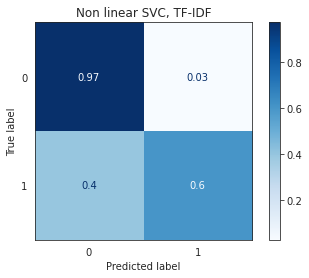

In [50]:
non_linear_svc = SVC(kernel='rbf', C=1, random_state=0)
non_linear_svc = cross_val(model=non_linear_svc, model_name="Non Linear SVC", x_train=x_train, y_train=y_train, vectorizer="TF-IDF")
model_plot_confusion_matrix(model=non_linear_svc, x_test=x_test, y_test=y_test, title="Non linear SVC, TF-IDF")

***Random Forest***


Presenting results of vectorizer: TF-IDF
-------------------------------------------------------------
Cross Validation iterations - test scores for Random Forest: [0.88099808 0.88076923 0.86538462 0.88076923 0.86538462]
Cross Validation iterations - train scores for Random Forest: [0.95625    0.94762134 0.95627102 0.95434887 0.95963479]

Random Forest average test score: 0.8747
Random Forest average train score: 0.9548



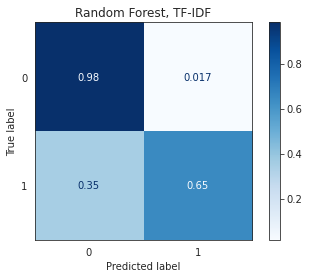

In [51]:
random_forest = RandomForestClassifier(max_depth=20)
random_forest = cross_val(model=random_forest, model_name="Random Forest", x_train=x_train, y_train=y_train, vectorizer="TF-IDF")
model_plot_confusion_matrix(model=random_forest, x_test=x_test, y_test=y_test, title="Random Forest, TF-IDF")

##**Conclusions**
The test scores of the four models are pretty similar. 

The models succeed with identifying Trump tweets, but not as much with identifying Staff tweets. A possible explanation - multiple staff members post tweets from the Presidential Twitter account, each with a unique writing style, making it hard to abstract patterns.

Future work - add a Neural Network classification model. 